# OPeNDAP

Allows to access netCDF file directly through the network. Most libraries that can read netCDF support OPeNDAP, so you can access the link as you would a file on disk.

In practice this works fairly well except when file access requires authentication, as with CMIP5. Then we need to handle certificates and the difficulty level increases. For this exercise, we'll use a simple test server to avoid these difficulties.

The advantage of using OPeNDAP is that you don't have to download the entire file. You can open the dataset remotely, access the time slice or the region of interest and make computation on the data. 

Some resources:
 * https://pypi.org/project/netcdf4_pydap/
 * https://portal.enes.org/data/data-metadata-service/search-and-download/opendap

In [1]:
%matplotlib inline
import numpy as np
import netCDF4 as nc

In [2]:
url = 'http://test.opendap.org:80/opendap/data/nc/20070917-MODIS_A-JPL-L2P-A2007260000000.L2_LAC_GHRSST-v01.nc'
D = nc.Dataset(url)
print(D.ncattrs())
D.variables.keys()

['title', 'DSD_entry_id', 'platform', 'sensor', 'Conventions', 'references', 'institution', 'contact', 'GDS_version_id', 'netcdf_version_id', 'creation_date', 'history', 'product_version', 'spatial_resolution', 'start_date', 'start_time', 'stop_date', 'stop_time', 'northernmost_latitude', 'southernmost_latitude', 'easternmost_longitude', 'westernmost_longitude', 'file_quality_index', 'comment']


odict_keys(['lat', 'lon', 'time', 'sea_surface_temperature', 'sst_dtime', 'proximity_confidence', 'SSES_bias_error', 'SSES_standard_deviation_error', 'rejection_flag', 'confidence_flag', 'sea_surface_temperature4', 'proximity_confidence4', 'SSES_bias_error4', 'SSES_standard_deviation_error4'])

In [3]:
lat = D.variables['lat'][:]
lon = D.variables['lon'][:]
time = D.variables['time']
print(time.units, time[0], nc.num2date(time[0], time.units))

seconds since 1981-01-01 00:00:00 842832339 2007-09-17 00:05:39


In [4]:
sst = D.variables['sea_surface_temperature']
print(sst.long_name)
print(sst.units)
print(sst.dimensions, sst.shape)

sea surface temperature
kelvin
('time', 'nj', 'ni') (1, 2030, 1354)


In [5]:
a = sst[:]

This dataset is problematic because it is entirely masked. We need to extract the data attribute to get to the original, unmasked values.

In [6]:
a.data

array([[[ -3575.,  -3529.,  -3483., ...,  -5279.,  -5268.,  -5239.],
        [ -3636.,  -3657.,  -3527., ...,  -5264.,  -5231.,  -5224.],
        [ -3669.,  -3703.,  -3696., ...,  -5270.,  -5284.,  -5243.],
        ...,
        [ -4451.,  -5568.,  -7066., ..., -32767., -32767., -32767.],
        [ -4392.,  -4950.,  -6888., ..., -32767., -32767., -32767.],
        [ -4524.,  -4661.,  -5933., ..., -32767., -32767., -32767.]]],
      dtype=float32)

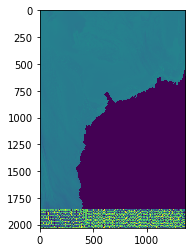

In [7]:
from matplotlib import pyplot as plt
plt.imshow(a.data[0])
plt.show()

## ESGF Access

For reference, here is how you would access ESGF data using OPeNDAP. Note that not all files are exposed through the OPeNDAP protocol... 

In [ ]:
import os
import xarray as xr
from pydap.cas.esgf import setup_session
# ds_url = "http://esgfcog.cccma.ec.gc.ca/thredds/dodsC/cmip5.output.CCCma.CanESM2.rcp85.mon.atmos.r4i1p1.pr.20130331.aggregation"
# The CCCMA server fails with an SSLError...
# ds_url = "https://esgf1.dkrz.de/thredds/dodsC/cmip5.output1.MPI-M.MPI-ESM-MR.rcp85.day.atmos.day.r1i1p1.uas.20120503.aggregation"
ds_url = "https://esgf1.dkrz.de/thredds/dodsC/cmip5.output1.MPI-M.MPI-ESM-MR.rcp85.mon.atmos.Amon.r1i1p1.pr.20120503.aggregation"
username = os.environ.get('ESGF_AUTH_USERNAME', '<your openid>')
password = os.environ.get('ESGF_AUTH_PASSWORD', '<password>')
session = setup_session(username, password, check_url=ds_url)
store = xr.backends.PydapDataStore.open(ds_url, session=session)
ds = xr.open_dataset(store)
ds.attrs